## Mise à Jour de la synthèse des connaissances sur les changements climatiques au Québec

### Températures
#### ERA-5 Land

All imports

In [5]:
import warnings
import logging
import xarray as xr
import xscen as xs
import xclim as xc
import cartopy.crs as ccrs
import cartopy.io.img_tiles as cimgt
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as cx

from pathlib import Path
from clisops.core import subset
from dask.diagnostics import ProgressBar
from dask.distributed import Client, progress, get_task_stream, wait
from dask import compute
from siphon.catalog import TDSCatalog
%matplotlib inline

warnings.simplefilter("ignore")

Loading the data from local disk `/tank`

<xarray.Dataset>
Dimensions:  (lat: 801, lon: 1700, time: 944)
Coordinates:
  * lat      (lat) float32 10.0 10.1 10.2 10.3 10.4 ... 89.6 89.7 89.8 89.9 90.0
  * lon      (lon) float32 -179.9 -179.8 -179.7 -179.6 ... -10.2 -10.1 -10.0
  * time     (time) datetime64[ns] 2020-01-01 2020-01-02 ... 2022-08-01
Data variables:
    tas      (time, lat, lon) float32 dask.array<chunksize=(168, 225, 252), meta=np.ndarray>
Attributes: (12/18)
    Conventions:       CF-1.9
    cell_methods:      time: mean (interval: 1 day)
    doi:               https://doi.org/10.24381/cds.e2161bac
    domain:            NAM
    frequency:         day
    history:           [2022-12-25 09:07:39.901698] Converted variables and m...
    ...                ...
    realm:             atmos
    source:            ERA5-Land
    table_date:        2022-12-21
    table_id:          ECMWF
    type:              reconstruction
    version:           v2022.12.23

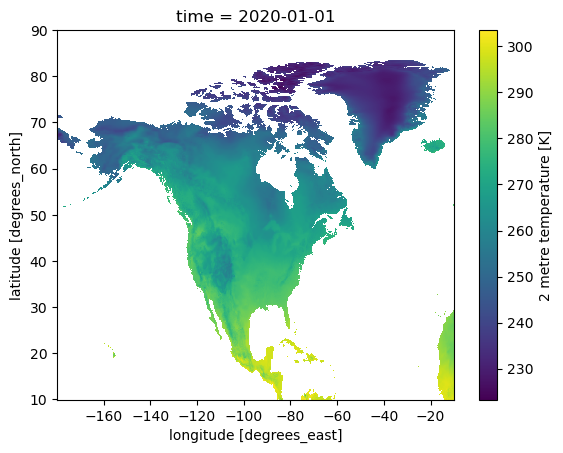

In [6]:
#Loading file from local disk
#ds = xr.open_mfdataset('/Users/marco/data/synthese23/era5-land/tas_day_ecmwf_era5-land_NAM_20*.zarr', engine='zarr')
#ds = xr.open_dataset('https://pavics.ouranos.ca/twitcher/ows/proxy/thredds/dodsC/datasets/reanalyses/day_ERA5-Land_NAM.ncml.html', engine='zarr') # ImportError: HTTPFileSystem requires "requests" and "aiohttp" to be installed
ds = xr.open_mfdataset('/tank/scenario/datasets/reconstruction/ECMWF/ERA5-Land/NAM/day/tas/tas_day_ecmwf_era5-land_NAM_202?.zarr', engine='zarr')
display(ds)
ds.tas.isel(time=0).plot()

Loading data from PAVICS catalog

['day_ERA5_NAM.ncml', 'day_ERA5-Land_NAM.ncml', '1hr_ERA5_NAM.ncml', '1hr_ERA5-Land_NAM.ncml']

<xarray.Dataset>
Dimensions:  (lat: 800, lon: 1700, time: 26298)
Coordinates:
  * lat      (lat) float32 10.0 10.1 10.2 10.3 10.4 ... 89.5 89.6 89.7 89.8 89.9
  * lon      (lon) float32 -179.9 -179.8 -179.7 -179.6 ... -10.2 -10.1 -10.0
  * time     (time) datetime64[ns] 1950-01-01 1950-01-02 ... 2021-12-31
Data variables:
    tas      (time, lat, lon) float32 dask.array<chunksize=(1280, 48, 48), meta=np.ndarray>
    tasmin   (time, lat, lon) float32 dask.array<chunksize=(1280, 48, 48), meta=np.ndarray>
    tasmax   (time, lat, lon) float32 dask.array<chunksize=(1280, 48, 48), meta=np.ndarray>
    pr       (time, lat, lon) float32 dask.array<chunksize=(1280, 48, 48), meta=np.ndarray>
    prsn     (time, lat, lon) float32 dask.array<chunksize=(1280, 48, 48), meta=np.ndarray>
Attributes: (12/26)
    Conventions:          CF-1.8
    cell_methods:         time: mean (interval: 1 day)
    data_specs_version:   00.00.07
    domain:               NAM
    format:               netcdf
    frequency:            day
    ...                   ...
    dataset_description:  https://www.ecmwf.int/en/era5-land
    license_type:         permissive
    license:              Please acknowledge the use of ERA5-Land as stated i...
    attribution:          Contains modified Copernicus Climate Change Service...
    citation:             Muñoz Sabater, J., (2021): ERA5-Land hourly data fr...
    doi:                  https://doi.org/10.24381/cds.e2161bac

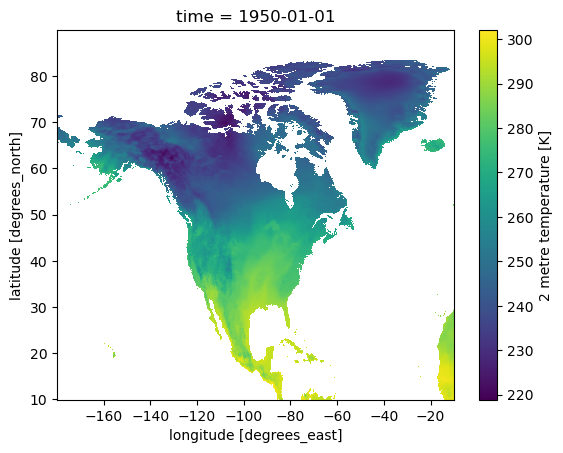

In [7]:
# Load a catalog of the data from PAVICS (same thing as file but with more attributes!)
url =  'https://pavics.ouranos.ca/twitcher/ows/proxy/thredds/catalog/datasets/reanalyses/catalog.html'

# Create Catalog
cat = TDSCatalog(url)

display(cat.datasets)
ds = xr.open_dataset(cat.datasets[1].access_urls["OPENDAP"], chunks = dict(time=256*5, lat=16*3, lon=16*3))
# URL directly
# ds = xr.open_dataset('https://pavics.ouranos.ca/twitcher/ows/proxy/thredds/dodsC/datasets/reanalyses/day_ERA5-Land_NAM.ncml')
display(ds)
ds.tas.isel(time=0).plot()

Loading data from catalog using `xscen`

Catalog for ERA5-Land

In [24]:
wdir = Path('/home/braun/python/obsflow/')
xs.load_config(str(wdir/'paths_obs.yml'), str(wdir/'config_obs.yml'), verbose=(__name__ == "__main__"), reset=True)
rec_cat = xs.CONFIG['extract']['reconstruction']['search_data_catalogs']['data_catalogs'][0]
print(f'DataCatalog for reconstruction (reanalysis): {rec_cat}')
dc = xs.DataCatalog(rec_cat)

#sorted(DC.search(source="ERA5-Land", frequency="1hr").unique("date_end"))
dc.df

2023-05-04 19:56:34 INFO     xscen.config    Updated the config with /home/braun/python/obsflow/paths_obs.yml.
2023-05-04 19:56:34 INFO     xscen.config    Updated the config with /home/braun/python/obsflow/config_obs.yml.


DataCatalog for reconstruction (reanalysis): /tank/scenario/catalogues/reconstruction-extra.json


,id,type,processing_level,bias_adjust_institution,bias_adjust_project,mip_era,activity,driving_institution,driving_model,institution,...,member,xrfreq,frequency,variable,domain,date_start,date_end,version,format,path
0,GouvCan_RDRS_NAM,reconstruction,raw,NaN,NaN,NaN,NaN,NaN,NaN,GouvCan,...,NaN,H,1hr,"(pr,)",NAM,1980-01-01 00:00,2018-12-31 23:00,v21,zarr,/jarre/logan/ECCC/RDRS_v21/converted/ECCC/RDRS...
1,GouvCan_RDRS_NAM,reconstruction,raw,NaN,NaN,NaN,NaN,NaN,NaN,GouvCan,...,NaN,H,1hr,"(tas,)",NAM,1980-01-01 00:00,2018-12-31 23:00,v21,zarr,/jarre/logan/ECCC/RDRS_v21/converted/ECCC/RDRS...
2,GouvCan_RDRS_NAM,reconstruction,raw,NaN,NaN,NaN,NaN,NaN,NaN,GouvCan,...,NaN,fx,fx,"(sftlf,)",NAM,NaT,NaT,v21,zarr,/jarre/logan/ECCC/RDRS_v21/converted/ECCC/RDRS...
3,GouvCan_RDRS_NAM,reconstruction,raw,NaN,NaN,NaN,NaN,NaN,NaN,GouvCan,...,NaN,fx,fx,"(sftof,)",NAM,NaT,NaT,v21,zarr,/jarre/logan/ECCC/RDRS_v21/converted/ECCC/RDRS...
4,GouvCan_RDRS_NAM,reconstruction,raw,NaN,NaN,NaN,NaN,NaN,NaN,GouvCan,...,NaN,fx,fx,"(mask,)",NAM,NaT,NaT,v21,zarr,/jarre/logan/ECCC/RDRS_v21/converted/ECCC/RDRS...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
865,GouvCan_NRCAN_NAM,reconstruction,raw,NaN,NaN,NaN,NaN,NaN,NaN,GouvCan,...,NaN,MS,mon,"(tasmax,)",NAM,1955-01-01 00:00,1955-12-31 23:00,NaN,nc,/tank/scenario/netcdf/nrcan/nrcan_northamerica...
866,GouvCan_NRCAN_NAM,reconstruction,raw,NaN,NaN,NaN,NaN,NaN,NaN,GouvCan,...,NaN,MS,mon,"(tasmax,)",NAM,1922-01-01 00:00,1922-12-31 23:00,NaN,nc,/tank/scenario/netcdf/nrcan/nrcan_northamerica...
867,GouvCan_NRCAN_NAM,reconstruction,raw,NaN,NaN,NaN,NaN,NaN,NaN,GouvCan,...,NaN,MS,mon,"(tasmax,)",NAM,2006-01-01 00:00,2006-12-31 23:00,NaN,nc,/tank/scenario/netcdf/nrcan/nrcan_northamerica...
868,GouvCan_NRCAN_NAM,reconstruction,raw,NaN,NaN,NaN,NaN,NaN,NaN,GouvCan,...,NaN,MS,mon,"(tasmax,)",NAM,1991-01-01 00:00,1991-12-31 23:00,NaN,nc,/tank/scenario/netcdf/nrcan/nrcan_northamerica...


In [23]:
sorted(dc.search(source="ERA5-Land", frequency="1hr").unique("date_end"))

ValueError: Catalog is empty.

In [25]:
rec_cats = xs.CONFIG['extract']['reconstruction']['search_data_catalogs']
cat_dict = xs.search_data_catalogs(**rec_cats)
display(cat_dict)
cat_dict['ECMWF_ERA5-Land_NAM'].df


2023-05-04 19:56:45 INFO     xscen.extract   Catalog opened: < catalog with 12 dataset(s) from 22028 asset(s)> from 2 files.
2023-05-04 19:56:45 INFO     xscen.extract   9594 assets matched the criteria : {'source': ['ERA5-Land', 'RDRS']}.
2023-05-04 19:56:45 INFO     xscen.extract   Iterating over 2 potential datasets.
2023-05-04 19:56:46 INFO     xscen.extract   Found 2 with all variables requested and corresponding to the criteria.


{'GouvCan_RDRS_NAM': < catalog with 1 dataset(s) from 3 asset(s)>,
 'ECMWF_ERA5-Land_NAM': < catalog with 1 dataset(s) from 219 asset(s)>}

,id,type,processing_level,bias_adjust_institution,bias_adjust_project,mip_era,activity,driving_institution,driving_model,institution,...,member,xrfreq,frequency,variable,domain,date_start,date_end,version,format,path
0,ECMWF_ERA5-Land_NAM,reconstruction,raw,NaN,NaN,NaN,NaN,NaN,NaN,ECMWF,...,NaN,D,day,"(tasmax,)",NAM,1958-01-01 00:00,1958-12-31 00:00,NaN,zarr,/tank/scenario/datasets/reconstruction/ECMWF/E...
1,ECMWF_ERA5-Land_NAM,reconstruction,raw,NaN,NaN,NaN,NaN,NaN,NaN,ECMWF,...,NaN,D,day,"(tasmax,)",NAM,2019-01-01 00:00,2019-12-31 00:00,NaN,zarr,/tank/scenario/datasets/reconstruction/ECMWF/E...
2,ECMWF_ERA5-Land_NAM,reconstruction,raw,NaN,NaN,NaN,NaN,NaN,NaN,ECMWF,...,NaN,D,day,"(tasmax,)",NAM,1980-01-01 00:00,1980-12-31 00:00,NaN,zarr,/tank/scenario/datasets/reconstruction/ECMWF/E...
3,ECMWF_ERA5-Land_NAM,reconstruction,raw,NaN,NaN,NaN,NaN,NaN,NaN,ECMWF,...,NaN,D,day,"(tasmax,)",NAM,1969-01-01 00:00,1969-12-31 00:00,NaN,zarr,/tank/scenario/datasets/reconstruction/ECMWF/E...
4,ECMWF_ERA5-Land_NAM,reconstruction,raw,NaN,NaN,NaN,NaN,NaN,NaN,ECMWF,...,NaN,D,day,"(tasmax,)",NAM,2001-01-01 00:00,2001-12-31 00:00,NaN,zarr,/tank/scenario/datasets/reconstruction/ECMWF/E...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
214,ECMWF_ERA5-Land_NAM,reconstruction,raw,NaN,NaN,NaN,NaN,NaN,NaN,ECMWF,...,NaN,D,day,"(pr,)",NAM,1976-01-01 00:00,1976-12-31 00:00,NaN,zarr,/tank/scenario/datasets/reconstruction/ECMWF/E...
215,ECMWF_ERA5-Land_NAM,reconstruction,raw,NaN,NaN,NaN,NaN,NaN,NaN,ECMWF,...,NaN,D,day,"(pr,)",NAM,1987-01-01 00:00,1987-12-31 00:00,NaN,zarr,/tank/scenario/datasets/reconstruction/ECMWF/E...
216,ECMWF_ERA5-Land_NAM,reconstruction,raw,NaN,NaN,NaN,NaN,NaN,NaN,ECMWF,...,NaN,D,day,"(pr,)",NAM,1972-01-01 00:00,1972-12-31 00:00,NaN,zarr,/tank/scenario/datasets/reconstruction/ECMWF/E...
217,ECMWF_ERA5-Land_NAM,reconstruction,raw,NaN,NaN,NaN,NaN,NaN,NaN,ECMWF,...,NaN,D,day,"(pr,)",NAM,2002-01-01 00:00,2002-12-31 00:00,NaN,zarr,/tank/scenario/datasets/reconstruction/ECMWF/E...


In [26]:
DC.unique('source')

NameError: name 'DC' is not defined

In [7]:
xs.__version__

'0.5.14-beta'

,PRUID,PRNAME,PRENAME,PRFNAME,PREABBR,PRFABBR,geometry
0,24,Quebec / Quï¿½bec,Quebec,Quï¿½bec,Que.,Qc,"MULTIPOLYGON (((-58.64703 51.20816, -58.63991 ..."


CPU times: user 2.66 s, sys: 144 ms, total: 2.8 s
Wall time: 3.27 s


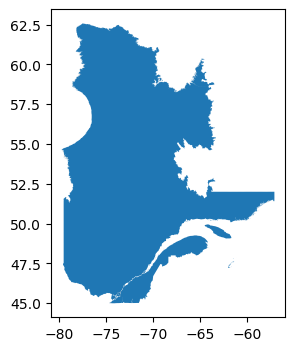

In [27]:
%%time
# load the shp-file directly from the zip file
#shape_file = "/Users/marco/Dropbox/SyntheseOuranosUpdate_ClimatHistorique/gis/CA_provinces.shp"
#shape_file = "/scen3/braun/data/synthese23/gis/lpr_000b16a_e_QC.zip!lpr_000b16a_e_QC.shp" # original resolution
shape_file = "/scen3/braun/data/obs_synthese23/gis/lpr_000b16a_e_QC_simpl1.zip!lpr_000b16a_e_QC_simpl1.shp" # intermediate resolution, simplyfy by 0.0001 degrees ~10m
#shape_file = "/scen3/braun/data/synthese23/gis/lpr_000b16a_e_QC_simpl.zip!lpr_000b16a_e_QC_simpl.shp" # coarser resolution, simplyfy by 0.0005 degrees ~50m

#shape_file = "/scen3/braun/data/synthese23/gis/CA_provinces.shp"

regions = gpd.read_file(shape_file)
    
# Display the first few columns
display(regions.head())

# Plot the layer to see what it looks like
a = regions.plot(figsize=(4, 4))

<xarray.Dataset>
Dimensions:  (lat: 176, lon: 224, time: 26298)
Coordinates:
  * lat      (lat) float32 45.0 45.1 45.2 45.3 45.4 ... 62.1 62.2 62.3 62.4 62.5
  * lon      (lon) float32 -79.5 -79.4 -79.3 -79.2 ... -57.5 -57.4 -57.3 -57.2
  * time     (time) datetime64[ns] 1950-01-01 1950-01-02 ... 2021-12-31
Data variables:
    tas      (time, lat, lon) float32 dask.array<chunksize=(1280, 34, 4), meta=np.ndarray>
    tasmin   (time, lat, lon) float32 dask.array<chunksize=(1280, 34, 4), meta=np.ndarray>
    tasmax   (time, lat, lon) float32 dask.array<chunksize=(1280, 34, 4), meta=np.ndarray>
    pr       (time, lat, lon) float32 dask.array<chunksize=(1280, 34, 4), meta=np.ndarray>
    prsn     (time, lat, lon) float32 dask.array<chunksize=(1280, 34, 4), meta=np.ndarray>
    crs      int64 1
Attributes: (12/27)
    Conventions:          CF-1.8
    cell_methods:         time: mean (interval: 1 day)
    data_specs_version:   00.00.07
    domain:               NAM
    format:               netcdf
    frequency:            day
    ...                   ...
    license_type:         permissive
    license:              Please acknowledge the use of ERA5-Land as stated i...
    attribution:          Contains modified Copernicus Climate Change Service...
    citation:             Muñoz Sabater, J., (2021): ERA5-Land hourly data fr...
    doi:                  https://doi.org/10.24381/cds.e2161bac
    crs:                  EPSG:4326

CPU times: user 4.09 s, sys: 2.05 s, total: 6.14 s
Wall time: 15.9 s


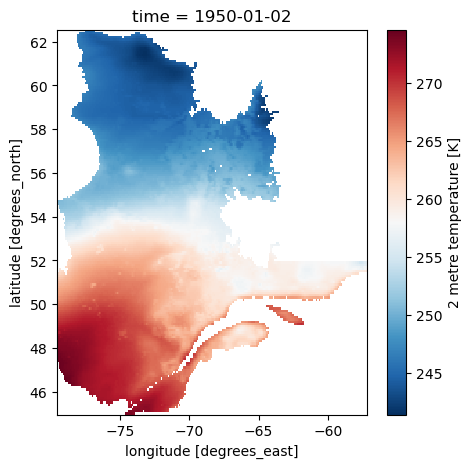

In [28]:
%%time
# Crop Quebec
# with ProgressBar():
ds_qc = subset.subset_shape(ds, shape=shape_file)

display(ds_qc)
a = ds_qc.tas.isel(time=1).plot(figsize=(5,5), cmap='RdBu_r') #'bwr') #'coolwarm')

In [10]:
#regions.loc[regions['NAME'] == 'Quebec'].plot() # if using "/scen3/braun/data/sythese23/gis/CA_provinces.shp"

In [29]:
def draw_map(data, ax, cmap, levels):
    # define the extent of the map
    lat_bnd = [44, 63]
    lon_bnd = [-82, -55]
    extent = lon_bnd + lat_bnd
    ax.set_extent(extent)
    # get a basemap from the internet
    sta = cimgt.Stamen(desired_tile_form='L', style='terrain')  # get Stamen background with labels
    ax.add_image(sta, 7, cmap='gray', zorder=2)
    
    # plot our data on top
    cbar = data.plot(ax=ax, zorder=3, alpha=0.5, transform=ccrs.PlateCarree(), cmap=plt.cm.get_cmap(cmap, levels))
    gl = ax.gridlines(zorder=4)
    gl.bottom_labels = True
    gl.left_labels = True
    #plt.show(block=False)
    return cbar

In [31]:
#fig, axes = plt.subplots(nrows=1, ncols=1, subplot_kw={'projection': ccrs.Mercator()}, figsize=(25, 30))
#fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(25, 30));
#display(fig.axes[0])
sta = cimgt.Stamen(desired_tile_form='L', style='terrain') # get Stamen background with names

fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot(1, 1, 1, projection=sta.crs)

cbar = draw_map(ds_qc.tas.isel(time=1), ax, 'RdBu_r', 256)

AttributeError: 'GeoAxes' object has no attribute '_autoscaleXon'

Error in callback <function _draw_all_if_interactive at 0x7f827215d550> (for post_execute):


AttributeError: 'GeoAxes' object has no attribute '_autoscaleXon'

AttributeError: 'GeoAxes' object has no attribute '_autoscaleXon'

<Figure size 700x700 with 1 Axes>

In [ ]:
# Use a custom yml module to define indicator calculations
obs_synth = xc.core.indicator.build_indicator_module_from_yaml("obs_synthese23", mode="raise")
obs_synth.tg_mean_annual

In [18]:
!pwd

/home/braun/python/obsflow


In [16]:
# define dask settings
dask_kwargs = dict(n_workers=6, threads_per_worker=4, memory_limit="3GB",
                    local_directory="/notebook_dir/writable-workspace/tmp", silence_logs=logging.ERROR)

# for obs/ra: What do we need to iterate over?
# - variables?
#  - different reanalysis?
for rcp in ['rcp45']:#,'rcp85']:
    for url_ds in urls[rcp]:
        # open and subset
        ds = xr.open_dataset(url_ds.access_urls["OPENDAP"], chunks = dict(time=256*5, lat=16*3, lon=16*3))
        ds = subset.subset_shape(ds, shape=shape)
        ds['tas'] = atmos.tg(ds=ds) # won't need
        ds_root_name = url_ds.name.replace('day_','').split('.nc')[0] # need to geet root name!

        for name, ind in obs_synth.iter_indicators():
            out_file = Path(ouput_folder) / f"indicators/{name}_{ds_root_name}.nc"
            if not out_file.exists():
                with Client(**dask_kwargs) as client:
                    display(client.dashboard_link)
                    print(ds_root_name,':', name)
                    dsout = xr.Dataset()
                    out = ind(ds=ds)
                    dsout[name] = out
                    dsout = xc.core.calendar.convert_calendar(dsout, 'standard', align_on='date') # will see if needed
                    dsout['time'] = dsout.indexes['time'].to_datetimeindex()
                    out_file.parent.mkdir(exist_ok=True)
                    dsout.to_netcdf(out_file)
            else:
                print(out_file.name, ' exists. Continuing ..')

NameError: name 'urls' is not defined

<xarray.Dataset>
Dimensions:  (lat: 801, lon: 1700, time: 944)
Coordinates:
  * lat      (lat) float32 10.0 10.1 10.2 10.3 10.4 ... 89.6 89.7 89.8 89.9 90.0
  * lon      (lon) float32 -179.9 -179.8 -179.7 -179.6 ... -10.2 -10.1 -10.0
  * time     (time) datetime64[ns] 2020-01-01 2020-01-02 ... 2022-08-01
Data variables:
    tas      (time, lat, lon) float32 dask.array<chunksize=(168, 225, 252), meta=np.ndarray>
Attributes: (12/18)
    Conventions:       CF-1.9
    cell_methods:      time: mean (interval: 1 day)
    doi:               https://doi.org/10.24381/cds.e2161bac
    domain:            NAM
    frequency:         day
    history:           [2022-12-25 09:07:39.901698] Converted variables and m...
    ...                ...
    realm:             atmos
    source:            ERA5-Land
    table_date:        2022-12-21
    table_id:          ECMWF
    type:              reconstruction
    version:           v2022.12.23

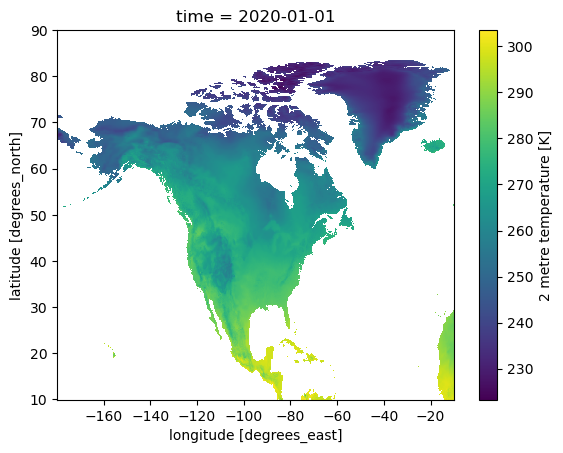

In [3]:
#Loading files for multiple years and writing them to one single file
import xarray as xr
ds = xr.open_mfdataset('/your_path/reconstruction/ECMWF/ERA5-Land/NAM/day/tas/tas_day_ecmwf_era5-land_NAM_202?.zarr', engine='zarr')
ds.to_netcdf('/your_path/braun/data/ERA5-Land_test-2020-2022.nc')

display(ds)
ds.tas.isel(time=0).plot()

In [2]:
!pwd

/home/braun/python/obsflow
